In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
import sklearn.metrics as metrics

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, linewidths=.5)

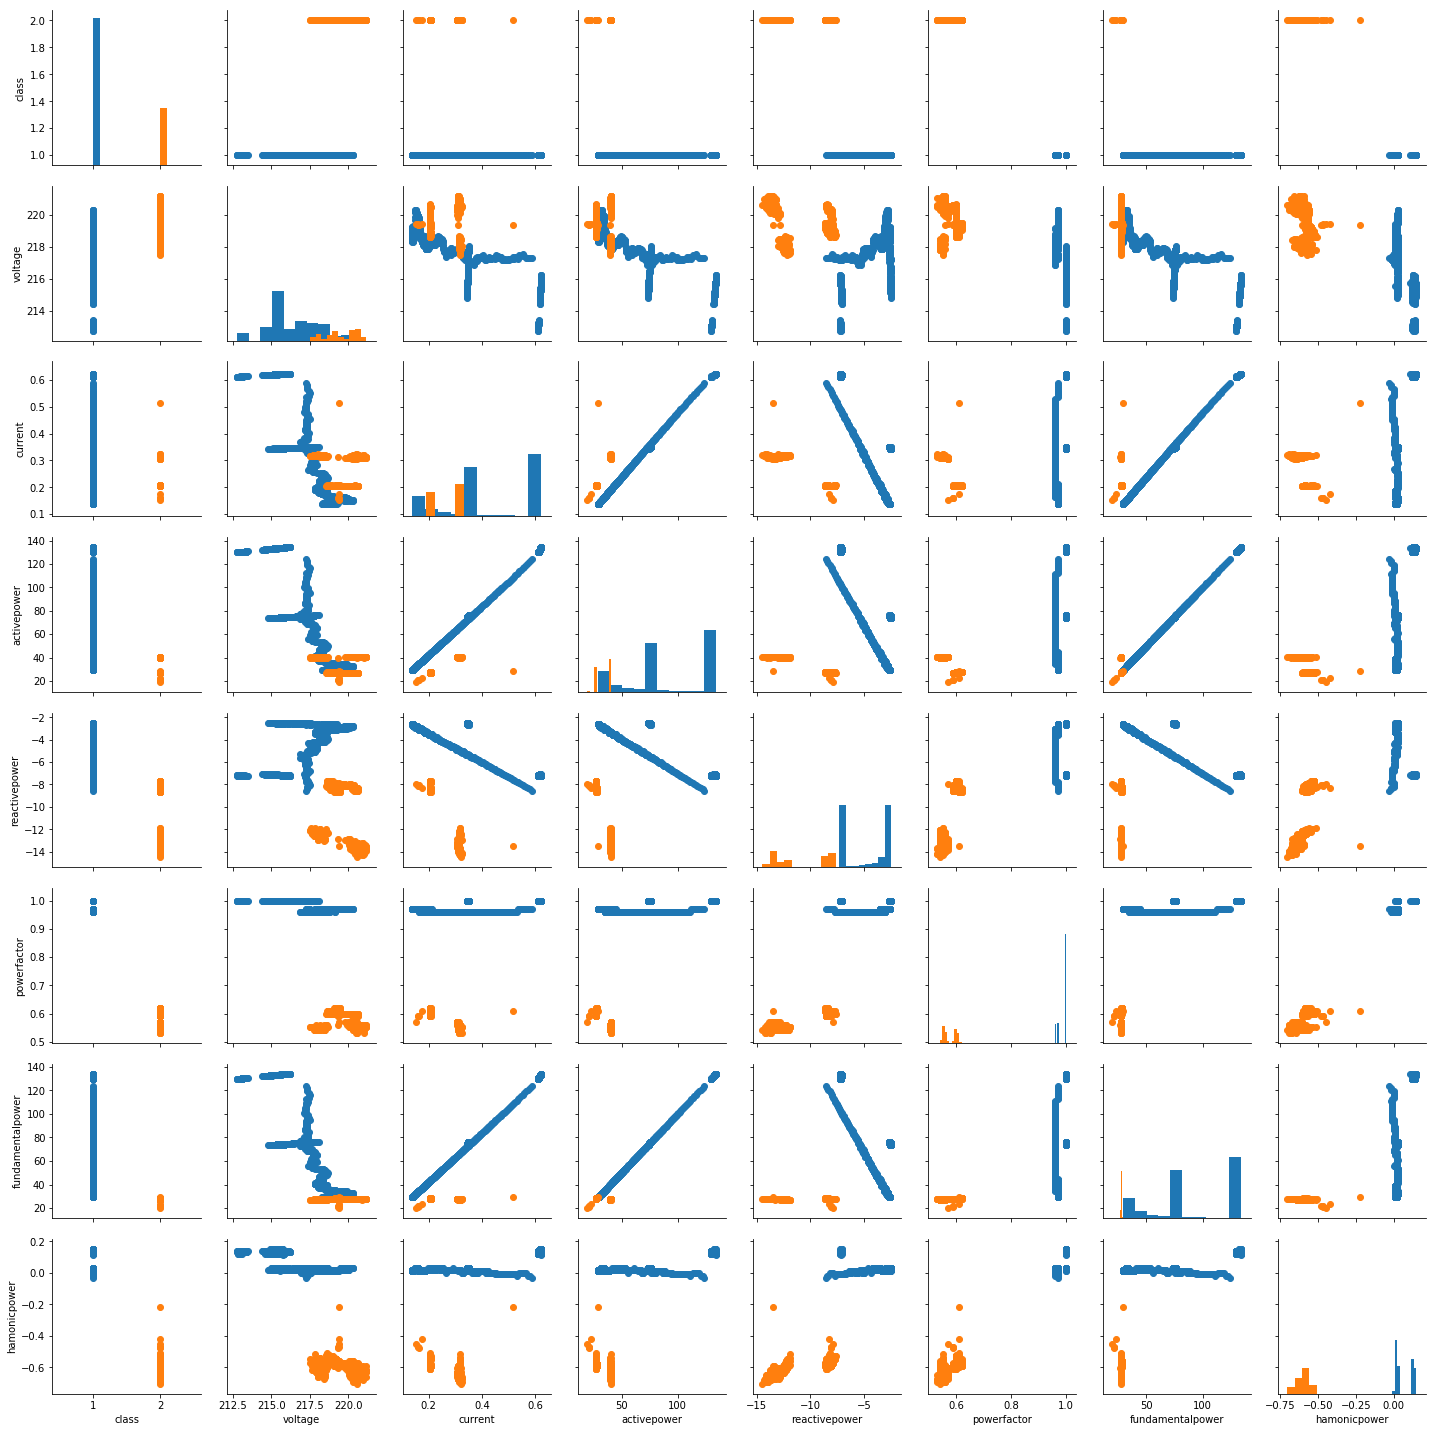

In [4]:
# Import data (exported from Postgree)
data = pd.read_csv ("../datasets/Labsmart EquipmentsData.csv", header=0);
    
g = sns.PairGrid(data, hue='class')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

## Set the timestamp as index
data['time'] = pd.to_datetime (data['time'])
data = data.set_index(data.time)

In [27]:
data.describe()

,class,voltage,current,activepower,reactivepower,powerfactor,fundamentalpower,hamonicpower
count,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000
mean,1.279776,217.271369,0.382619,75.728124,-6.532604,0.874647,73.718164,-0.118797
std,0.448946,2.024404,0.168512,41.345026,3.585608,0.187375,43.180554,0.304872
min,1.000000,212.790000,0.138000,19.370001,-14.496001,0.532000,19.820000,-0.704000
25%,1.000000,215.496000,0.225100,40.005000,-7.990000,0.610000,27.840000,-0.550000
50%,1.000000,217.288000,0.344300,73.959999,-7.140000,1.000000,73.940000,0.020000
75%,2.000000,218.889000,0.617800,132.460007,-2.640000,1.000000,132.330000,0.130000
max,2.000000,221.169000,0.622800,134.479996,-2.470000,1.000000,134.340000,0.150000


In [8]:
## Resample
resampled = data.resample('5S').agg({'class':['mean', 'count'],
                                      'voltage': 'mean',
                                      'current':['mean','var'],
                                      'activepower': 'mean',
                                      'reactivepower': 'mean',
                                      'powerfactor': 'mean',
                                      'fundamentalpower': 'mean',
                                      'hamonicpower':['mean','var']
                                     })
resampled.columns = resampled.columns.map('_'.join)
resampled = resampled.query('class_count > 3')
resampled = resampled.drop('class_count', axis=1)
resampled.head()

,class_mean,voltage_mean,current_mean,current_var,activepower_mean,reactivepower_mean,powerfactor_mean,fundamentalpower_mean,hamonicpower_mean,hamonicpower_var
time,,,,,,,,,,
2019-03-20 05:08:45,1.0,213.2108,0.61266,7.299681e-08,130.423999,-7.226,1.0,130.294,0.132,0.00002
2019-03-20 05:08:50,1.0,213.2164,0.61254,1.800121e-08,130.404001,-7.222,1.0,130.274,0.134,0.00003
2019-03-20 05:08:55,1.0,213.0180,0.61196,2.800154e-08,130.163998,-7.218,1.0,130.036,0.130,0.00000
2019-03-20 05:09:00,1.0,212.9112,0.61172,1.200398e-08,130.046002,-7.210,1.0,129.912,0.130,0.00005
2019-03-20 05:09:05,1.0,212.9644,0.61190,4.998680e-09,130.109998,-7.218,1.0,129.974,0.136,0.00003


In [9]:
# minMax normalization 
normalized=(resampled-resampled.min())/(resampled.max()-resampled.min())
normalized

,class_mean,voltage_mean,current_mean,current_var,activepower_mean,reactivepower_mean,powerfactor_mean,fundamentalpower_mean,hamonicpower_mean,hamonicpower_var
time,,,,,,,,,,
2019-03-20 05:08:45,0.0,0.041508,0.979443,2.871551e-06,0.964496,0.587167,1.000000,0.964348,0.982956,0.001617
2019-03-20 05:08:50,0.0,0.042188,0.979195,7.081320e-07,0.964318,0.587516,1.000000,0.964169,0.985391,0.002425
2019-03-20 05:08:55,0.0,0.018081,0.977998,1.101526e-06,0.962180,0.587864,1.000000,0.962038,0.980521,0.000000
2019-03-20 05:09:00,0.0,0.005103,0.977503,4.722130e-07,0.961129,0.588561,1.000000,0.960928,0.980521,0.004042
2019-03-20 05:09:05,0.0,0.011568,0.977874,1.966382e-07,0.961699,0.587864,1.000000,0.961483,0.987826,0.002425
...,...,...,...,...,...,...,...,...,...,...
2019-03-20 06:40:45,1.0,0.601303,0.372198,4.912358e-05,0.158698,0.146382,0.012484,0.041203,0.088386,0.001956
2019-03-20 06:40:50,1.0,0.599950,0.367864,1.770113e-06,0.158791,0.135648,0.016645,0.041343,0.076779,0.002608
2019-03-20 06:40:55,1.0,0.606989,0.367492,2.761547e-05,0.158831,0.141921,0.016645,0.041346,0.080351,0.002935


,voltage,current,activepower,reactivepower,powerfactor,fundamentalpower,hamonicpower
time,,,,,,,
2019-03-20 05:08:43,213.276,0.61280,130.490005,-7.210,1.0000,130.36,0.130
2019-03-20 05:08:44,213.305,0.61280,130.509995,-7.220,1.0000,130.39,0.130
2019-03-20 05:08:45,213.251,0.61290,130.520004,-7.230,1.0000,130.39,0.130
2019-03-20 05:08:46,213.181,0.61240,130.339996,-7.220,1.0000,130.21,0.130
2019-03-20 05:08:47,213.171,0.61250,130.360001,-7.220,1.0000,130.23,0.130
...,...,...,...,...,...,...,...
2019-03-20 06:41:06,217.947,0.31830,39.974999,-12.144,0.5415,27.17,-0.572
2019-03-20 06:41:07,217.954,0.31920,40.050001,-12.144,0.5415,27.23,-0.583
2019-03-20 06:41:08,217.980,0.31905,39.974999,-12.128,0.5415,27.18,-0.583


In [30]:
y.shape

(3921,)

In [31]:
# Separa as colunas
X = data.drop(['time', 'class'], axis=1)
y = data['class']

#Treina o modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50) 
classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1424
           2       1.00      1.00      1.00       537

    accuracy                           1.00      1961
   macro avg       1.00      1.00      1.00      1961
weighted avg       1.00      1.00      1.00      1961



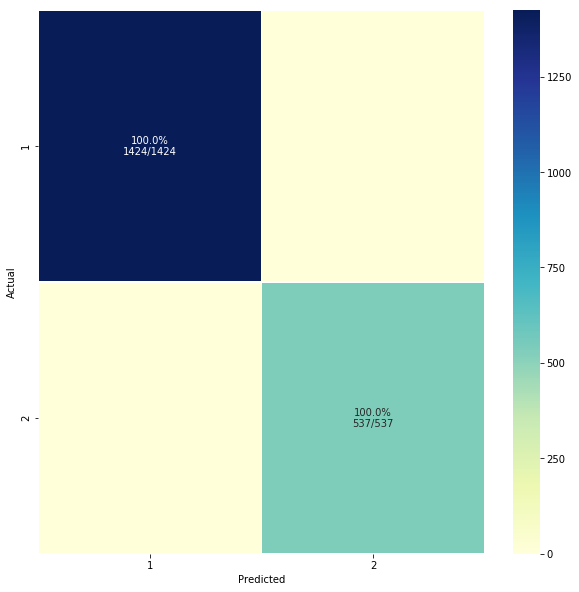

In [32]:
# Predic
y_pred = classifier.predict(X_test)  

#Analyse
plot_cm(y_test, y_pred)
print(classification_report(y_test, y_pred))
